# Analyzing MC-results for clearance experiments (and last-mile computations)

Here, we'll take the raw outputs from the experiments and post-process them into the final Monte-Carlo results we'll be looking for.
An entry of one MC-iteration is the relevant experiment params (clearance, n_samples in the PRM, dimension), and the `threshold' number of neighbors/radius to find a feasible path (fewer neighbors/shorter results in no path solve). 

This allows is to use the threshold to compute the probability of a wide range of radii/neighbors (have a discrete grid of radii/neighbors, increment the ones above the threshold).

In [1]:
%cd ~/Research/nonasymptotic-mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools as it
import json
import glob
import os

/home/seiji/Research/nonasymptotic-mp


In [2]:
# load in the experiment and set plotting params
exp_name = 'narrow-full-run-radius2_20240611-152454'
exp_path = os.path.join('exps', 'results', exp_name)


Loading in the experiment log:

In [3]:
out_paths = glob.glob(os.path.join(exp_path, 'out*.csv'))
out_df = pd.concat(map(lambda x: pd.read_csv(x, index_col=0), out_paths))

exp_config = json.load(open(os.path.join(exp_path, 'config.json'), 'r'))
max_rad = exp_config['radius_prm_max_radius']
max_knn = exp_config['knn_prm_max_neighbors']

#n_radii = 100
# rads = np.linspace(out_df['conn_lb'].min(), max_rad, num=n_radii)
rads = np.array(exp_config['deltas']) * 2
n_radii = len(rads)

In [4]:
exp_config

{'deltas': [0.499, 0.25, 0.125, 0.0625],
 'radius_dims_to_test': [2, 3, 4, 5, 6],
 'radius_sample_schedule': [100, 1000],
 'radius_prm_max_radius': 1.0,
 'knn_dims_to_test': [],
 'knn_sample_schedule': [],
 'knn_prm_max_neighbors': 4,
 'n_trials': 100,
 'name': 'narrow-full-run-radius2',
 'triples': [8, 1, 48]}

Doing the MC-computation for radius/knns

In [5]:
# first prep the corresponding counters for all the mc trials. 
# we'll do a relatively naive dictionary-type thing, and convert floats to strings to use as keys
# create iterators for each experiment type and stack them together
radius_trials_iter = it.product(
    ['radius'],  # need this for proper indexing into the pandas array
    exp_config['deltas'],
    exp_config['radius_dims_to_test'],
    exp_config['radius_sample_schedule'],
)

knn_trials_iter = it.product(
    ['knn'],  # need this for proper indexing into the pandas array
    exp_config['deltas'],
    exp_config['knn_dims_to_test'],
    exp_config['knn_sample_schedule'],
)

all_trials_iter = it.chain(radius_trials_iter, knn_trials_iter)
estimate_dict = {}

for prm_type, clearance, dim, n_samples in all_trials_iter:
    _clearance = str(clearance)

    # filter for the specific trial type
    mc_trial_rows = out_df[
        (out_df['prm_type'] == prm_type) &
        (out_df['dim'] == dim) &
        np.isclose(out_df['delta_clearance'], clearance) &
        (out_df['n_samples'] == n_samples)
        ]

    if prm_type == 'knn':
        conn_thresh_arr = np.tile(
            mc_trial_rows['conn_ub'].to_numpy().reshape(-1, 1),
            (1, max_knn)
        )
        conn_cmp_arr = np.tile(np.arange(max_knn), (conn_thresh_arr.shape[0], 1))
    else:
        conn_thresh_arr = np.tile(
            mc_trial_rows['conn_ub'].to_numpy().reshape(-1, 1),
            (1, n_radii)
        )
        conn_cmp_arr = np.tile(rads, (conn_thresh_arr.shape[0], 1))

    above_threshold = conn_cmp_arr >= conn_thresh_arr
    
    
    estimates = np.sum(above_threshold, axis=0) / len(mc_trial_rows) if len(mc_trial_rows) != 0 else np.sum(above_threshold, axis=0) * np.nan
        
    estimate_dict[(prm_type, _clearance, dim, n_samples)] = estimates

Plotting results:
This isn't the final version of the plot (since we need to tabulate the data anyway because there is too much otherwise),
but these line plots is a good way to understand how the empirical probability changes as the
radius changes.

We'll also compare against the theoretical bound too. We'll work with the feasibility version.
For passage of clearance $\delta$, then we'll require a $\delta/4$-net and a connection radius
of $2\delta$. 

If the largest radius turns out to be smaller than $2\delta$, then we'll just compute
the bound for the corresponding smaller net (as dictated by the radius). We'll need to expect some
looseness for that scenario. NOTE: We tried this, and it turns out the numerical bound computation is vacuous in this scenario. Even just using the largest net rad as dictated by the environment is off by a full order of magnitude.

A more useful thing to do is to compare the number of samples required by the env for the
success rate of the PRM of a particular net size. This may be more useful anyway, since
getting the sample count roughly right is the real goal -- not estimating the prob

/tmp/ipykernel_1330478/1448554625.py:63: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(data=radius_plot_df, x='conn', y='predicted_used_samples', row='dim', col='clearance', hue='n_samples', style="p_type",


<Figure size 640x480 with 0 Axes>

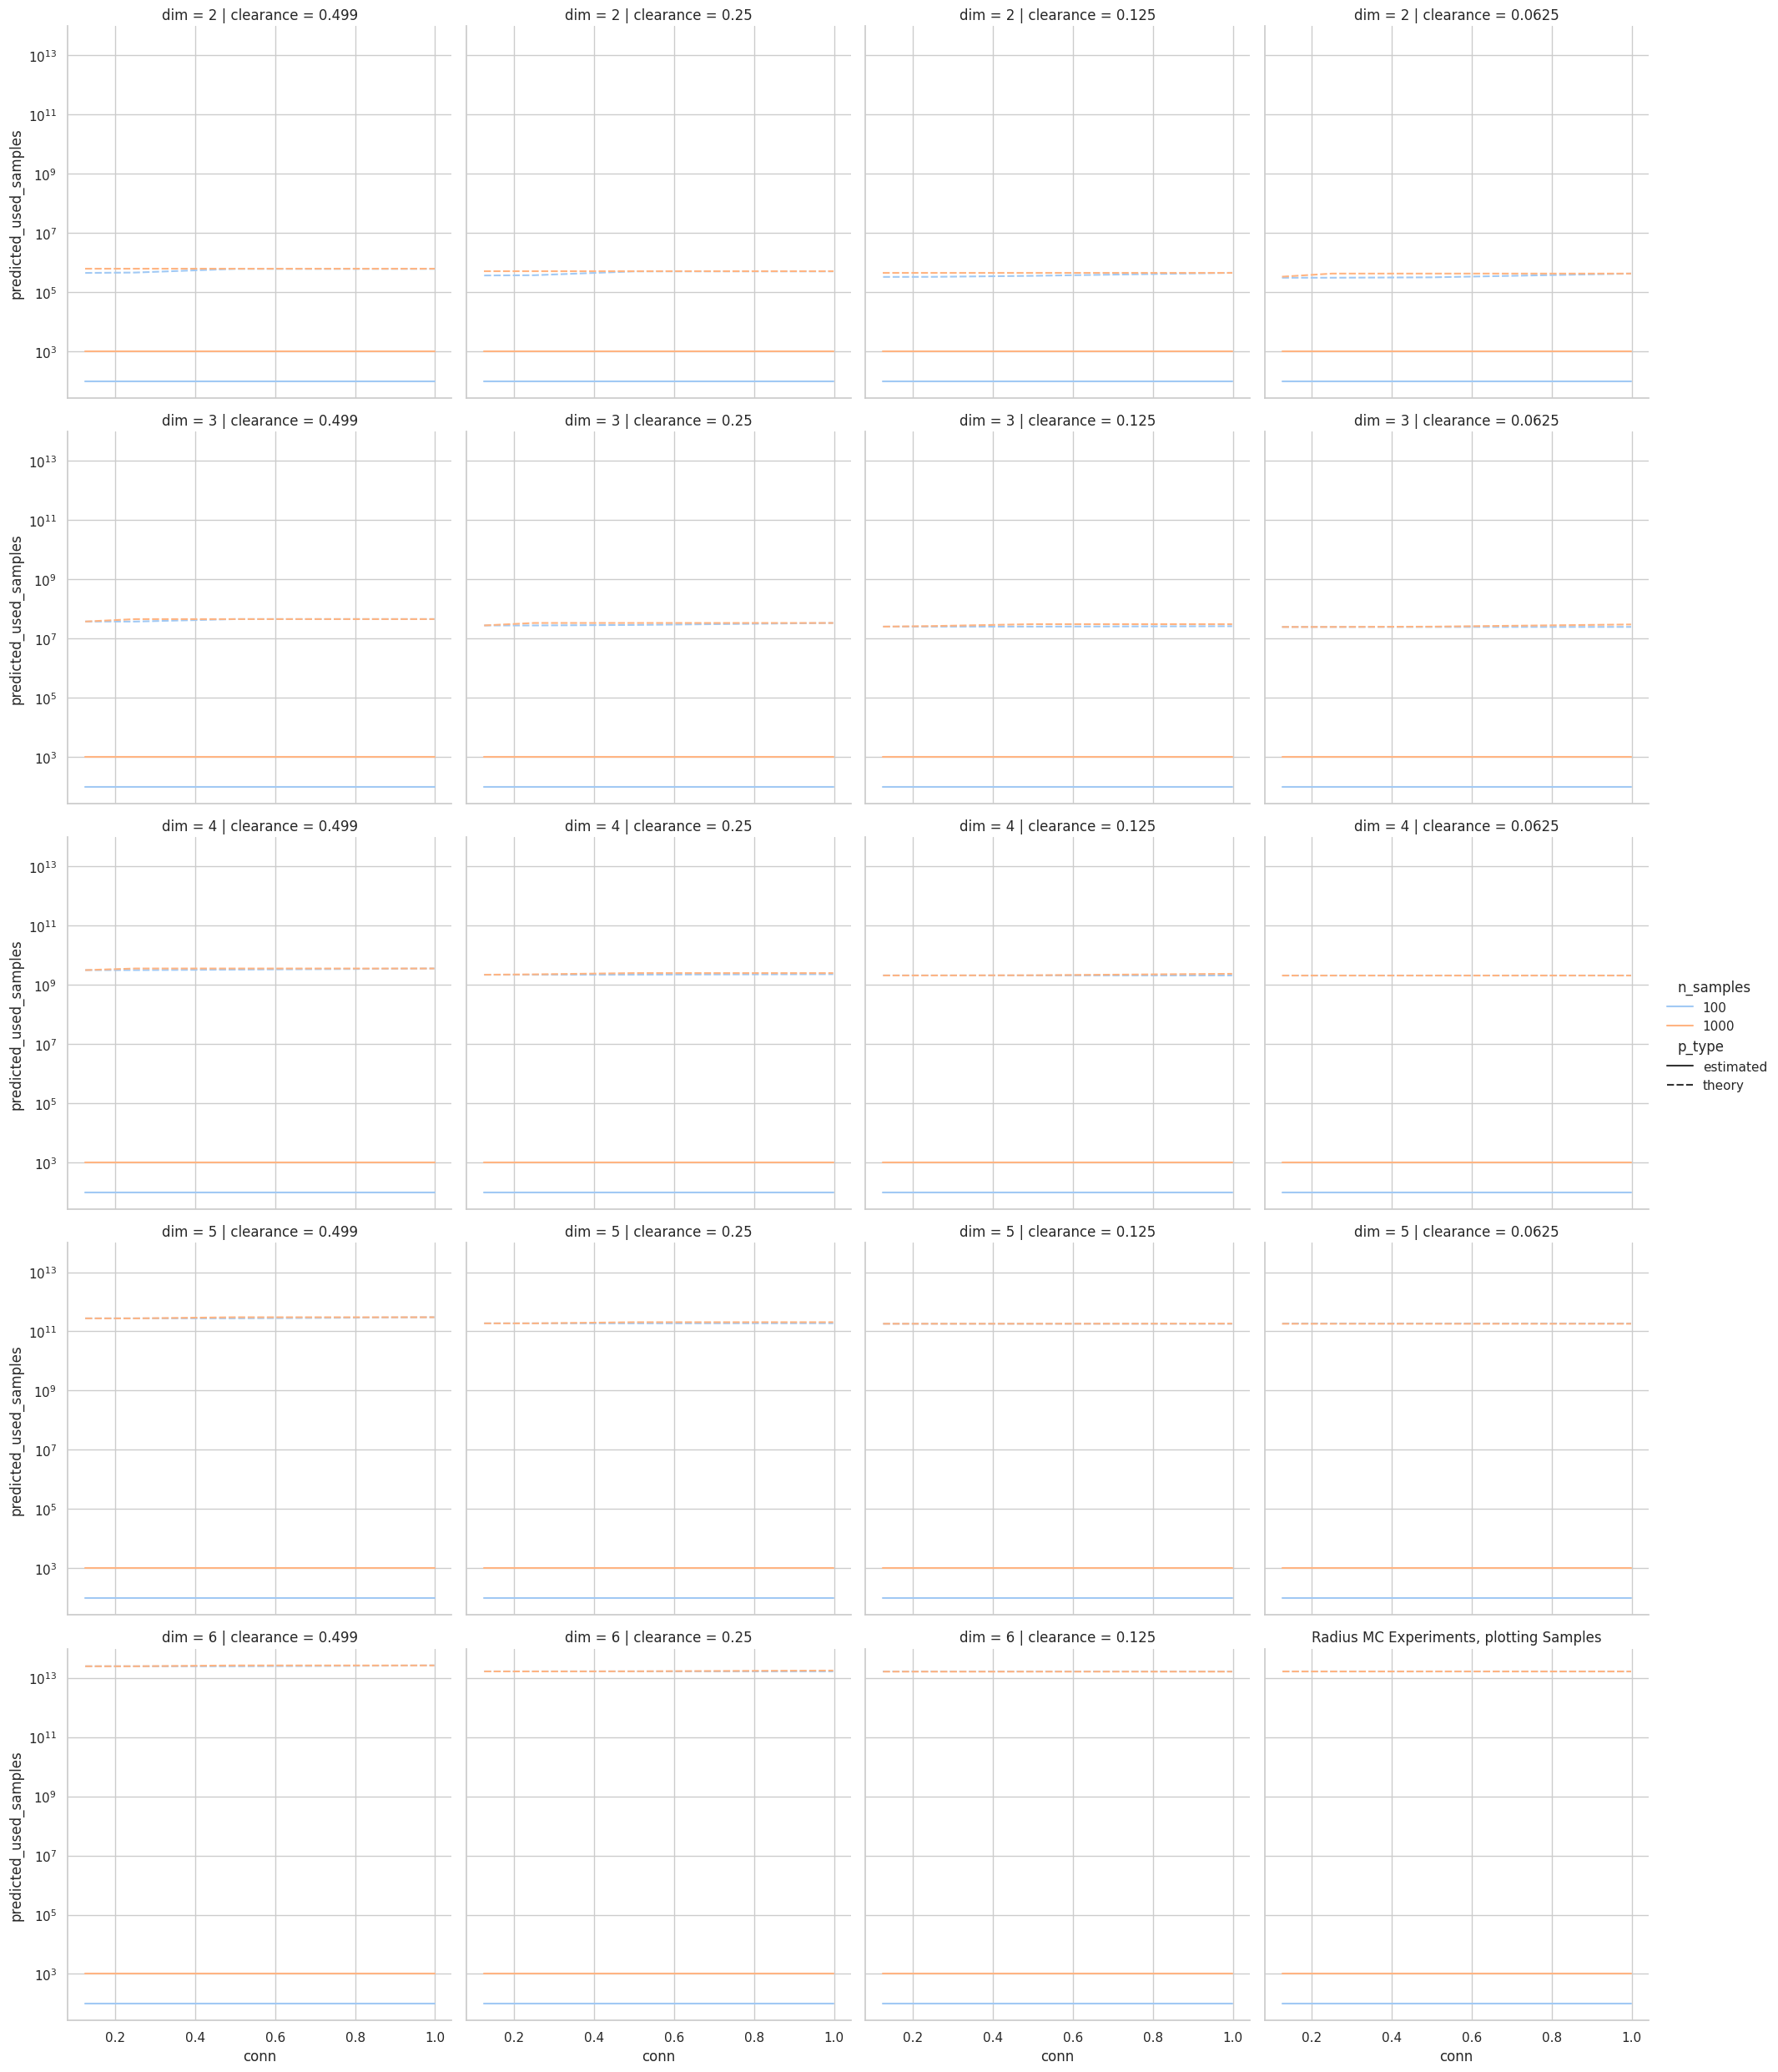

/tmp/ipykernel_1330478/1448554625.py:72: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.relplot(data=radius_plot_df[radius_plot_df['p_type'] == 'estimated'], x='conn', y='p', row='dim', col='clearance', hue='n_samples', style='p_type',


<Figure size 640x480 with 0 Axes>

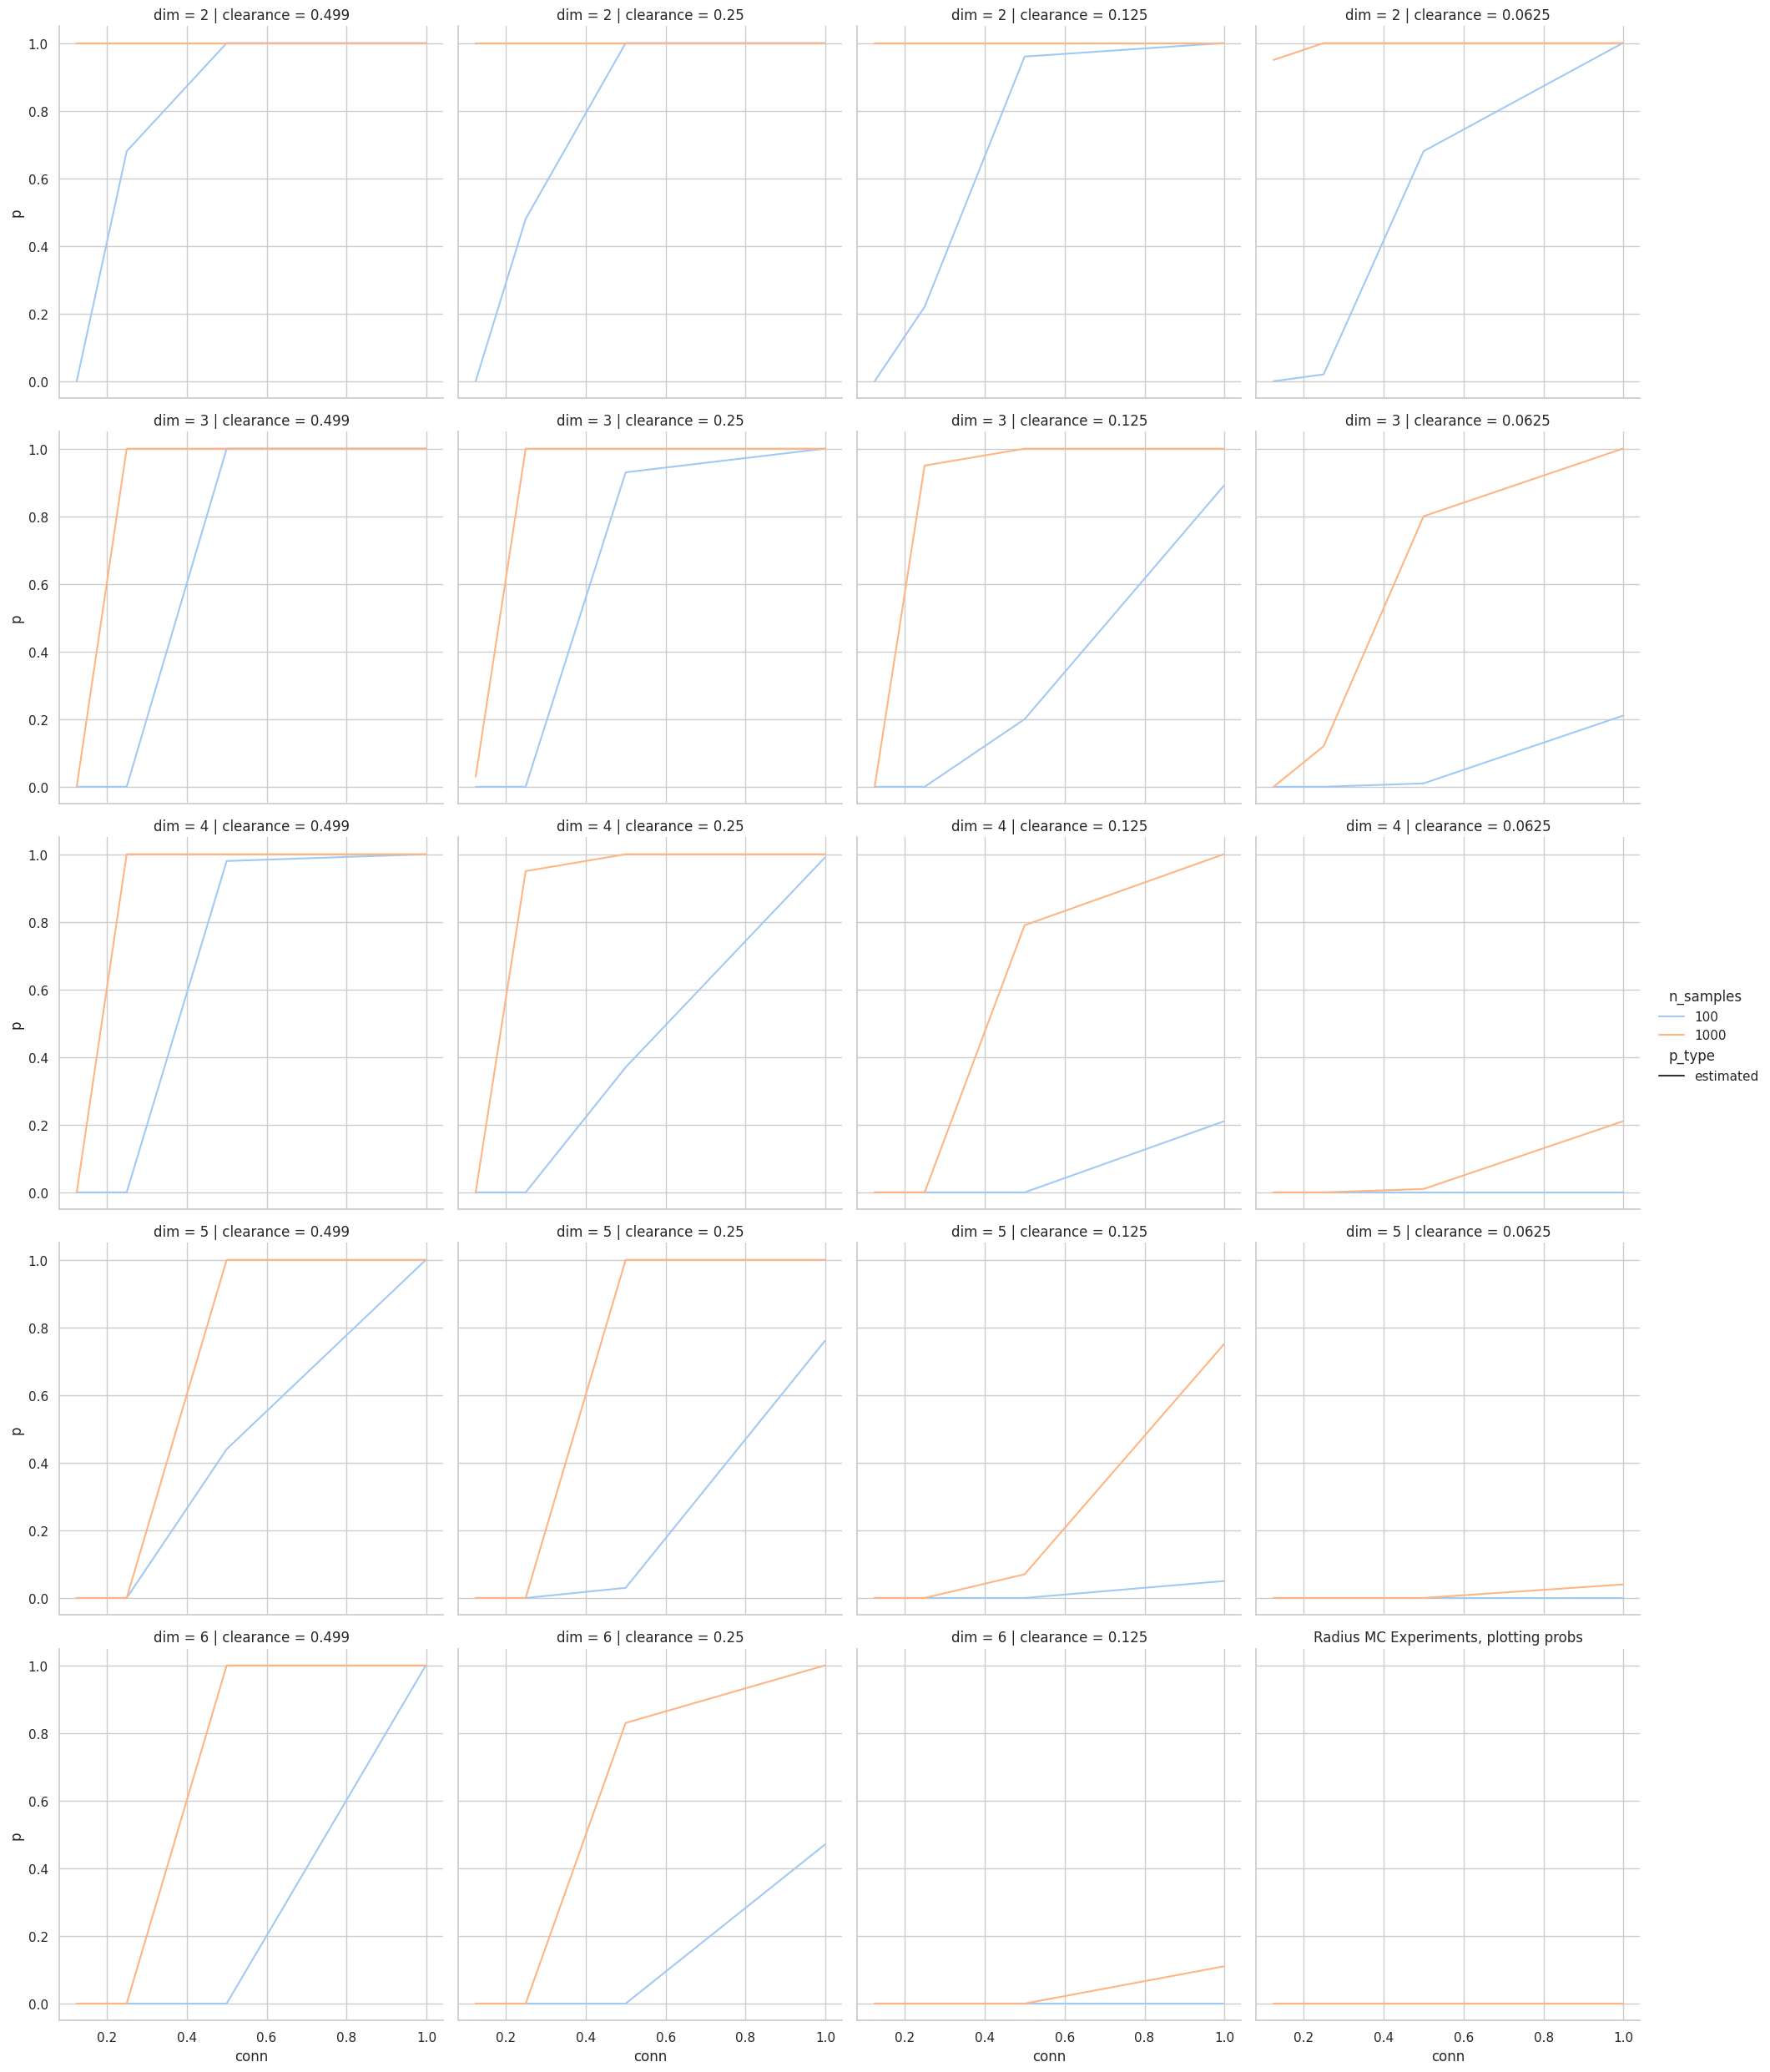

/tmp/ipykernel_1330478/1448554625.py:79: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(data=knn_plot_df, x='conn', y='p', row='dim', col='clearance', hue='n_samples', style='p_type',


<Figure size 640x480 with 0 Axes>

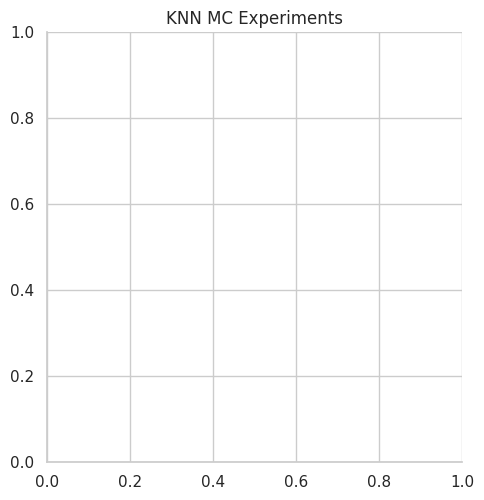

In [6]:
from nonasymptotic.bound import compute_sauer_shelah_bound_log2, compute_vol_unit_sphere, \
    doubling_sample_search_over_log2_prob_bound
from nonasymptotic.envs import NarrowPassage
machine_eps = 1e-6
# recompile the results into a dataframe and then use seaborn to plot.
# the most efficient way to do this is to set up each array separately and then concatenate
plot_dfs = []
for prm_type, _clearance, dim, n_samples in estimate_dict.keys():
    clearance = float(_clearance)
    estimates = estimate_dict[(prm_type, _clearance, dim, n_samples)]

    # if the estimate is nan, then it hasn't been processed yet by the experiments. so we skip.
    if np.isnan(estimates[-1]):
        continue

    # put estimates format amenable for dataframe
    dict_for_df = {
        "p": estimates,
        "conn": np.arange(max_knn) if prm_type == 'knn' else rads,
        "p_type": ["estimated"] * max_knn if prm_type == 'knn' else ["estimated"] * n_radii,
        "n_samples": [n_samples] * max_knn if prm_type == 'knn' else [n_samples] * n_radii,
        "predicted_used_samples": [n_samples] * max_knn if prm_type == 'knn' else [n_samples] * n_radii,
    }

    if prm_type == 'radius' and dim <= 7: # needed since numerics of higher dims craps out computation
#         print('processing: ' + str((prm_type, clearance, dim, n_samples)))
        # compute corresponding theoretical quantities (using smallest Sauer-Shelah expression)
        vol_env = NarrowPassage(dim, clearance, seed=1999).vol
        net_rads = np.minimum(rads / 8, clearance / 4)  # clip for net radius corresponding to clearance of the passage
        rhos = (compute_vol_unit_sphere(dim) / vol_env) * (net_rads ** dim)

        # compute what the bound would say now. 
        log2_ss_probs = np.array([compute_sauer_shelah_bound_log2(n_samples, _rho, dim + 1) for _rho in rhos])
        ss_probs = 2 ** log2_ss_probs

        # compute what the number samples _would_ be given the MC estimate. 
        ss_log2_bound_funcs = [lambda _ns: compute_sauer_shelah_bound_log2(_ns, _rho, dim + 1) for _rho in rhos]
        pred_samples = [
            doubling_sample_search_over_log2_prob_bound(_bf, _sp - machine_eps)
            for _bf, _sp in zip(ss_log2_bound_funcs, estimates)
        ]

        dict_for_df['p'] = np.concatenate([dict_for_df['p'], ss_probs])
        dict_for_df['conn'] = np.concatenate([dict_for_df['conn'], rads])
        dict_for_df['p_type'] += ["theory"] * n_radii
        dict_for_df['n_samples'] += [n_samples] * n_radii
        dict_for_df['predicted_used_samples'] += pred_samples

    # construct dataframe
    _df = pd.DataFrame(dict_for_df)
    _df['prm_type'] = prm_type
    _df['clearance'] = _clearance
    _df['dim'] = dim
    plot_dfs.append(_df)
plot_df = pd.concat(plot_dfs)

# in this scenario, it makes sense to plot knn and radius prms separately
radius_plot_df = plot_df[plot_df['prm_type'] == 'radius']
knn_plot_df = plot_df[plot_df['prm_type'] == 'knn']

plt.figure()
sns.set_theme(style="whitegrid")
g = sns.relplot(data=radius_plot_df, x='conn', y='predicted_used_samples', row='dim', col='clearance', hue='n_samples', style="p_type",
            kind='line', palette=sns.color_palette("pastel"))
g.set(yscale='log')
plt.title('Radius MC Experiments, plotting Samples')
plt.show()

# here, the theoretical bound is ommited (since it's vacuous)
plt.figure()
sns.set_theme(style="whitegrid")
sns.relplot(data=radius_plot_df[radius_plot_df['p_type'] == 'estimated'], x='conn', y='p', row='dim', col='clearance', hue='n_samples', style='p_type',
            kind='line', palette=sns.color_palette("pastel"))
plt.title('Radius MC Experiments, plotting probs')
plt.show()

plt.figure()
sns.set_theme(style="whitegrid")
sns.relplot(data=knn_plot_df, x='conn', y='p', row='dim', col='clearance', hue='n_samples', style='p_type',
            kind='line', palette=sns.color_palette("pastel"))
plt.title('KNN MC Experiments')
plt.show()

## Intermediate Observations and Experiment Refinements

Some interesting observations from these intermediate results:
We find that the bound is loose 1-2 orders of magnitude (decimal) for radii, and gets looser as the dimensions creep up (e.g. there are bad dimension-dependant constants that need to be corrected).

In KNN PRM plots: but a percolation thresholding effect seems to be apparent as with wider passages and more samples (the degree to which is influenced by dimension).

For radii, it's clear that it's not worth testing more than six or seven dimensions. For KNN PRMs, it's probably worth going up to 20, since we still see some degree of success in the higher dimensions.

Radius experiment changes:

1. Cap the radius experiments to six/seven dimensions.
    
2. Adjust the passage widths so the maximum radius is theoretically sound for _all_ of them (negative powers of two sounds reasonable).

KNN experiment changes:

1. Match the clearance to the radius experiments. Take a coarser set of dims to run -- choose to only test one of six or seven, for example -- so we can get snappier runtimes.

2. The fine grained-neighbor evaluation is super interesting, and is cool experimental evidence for percolation thresholds etc. But that study is orthogonal to the rest of the paper. Limit the search to the log-power 2 scale... then the final neighbor threshold step goes from `T(check_rt) * log(max_knn)` to `T(check_rt) * log(log(max_knn))`. 


For all experiments:
1. Record path length and number of edges. This sort of data can help us diagnose if the event the bound discusses is the reason for why the path is constructed (which comments on tightness too).

## Final Outputs for Deliverables
With a more refined experiment setup, we now generate the latex tables (given the data above) to copy-paste into the paper.

In [51]:
import pytextable
n_rows = 2

# First, prep the data. 
# We're interested in the radii that corresponds to the prescribed connection radius.
# radius as given in the theorem.

# create a list of tables and output them one by one.
# first, split them up by dimension,
deltas = exp_config['deltas']
sample_schedule = exp_config['radius_sample_schedule']
ds = exp_config['radius_dims_to_test']

# the order of the table is:

data_by_ds = list(
    map(
        lambda _d: radius_plot_df[radius_plot_df['dim'] == _d],
        ds
    )
)

# then, put the tables together box by box: columns go by samples, rows go by clerance
final_tables = []
for _data_df in data_by_ds:
    _table = []
    
    for delta in deltas:
        row = []
        row.append(delta)
        
        for n_samples in sample_schedule:
            box_items = _data_df[(_data_df['n_samples'] == n_samples) 
                                & np.isclose(_data_df['conn'], delta * 2) 
                                & np.isclose(_data_df['clearance'].astype('float'), delta)]
            estimated_p = box_items[box_items['p_type'] == 'estimated']['p'].to_list()[0]
            samples_used = box_items[box_items['p_type'] == 'estimated']['n_samples'].to_list()[0]
            samples_predicted = box_items[box_items['p_type'] == 'theory']['predicted_used_samples'].to_list()[0]
            
            row.append('%.2f/%s' % (estimated_p, np.format_float_scientific(samples_predicted / samples_used, precision=2)))
        
        _table.append(row)
    final_tables.append(_table)
            
           
           

# stick together the latex with outside-table formatting latex
parbox_room = '%.2f' % ((1 / n_rows) - (1 / 100))
out_str = ''
str_sample_schedule = list(map(lambda _i: '$n=%i$'%_i, sample_schedule))
for it, _table in enumerate(final_tables):
    table_str = pytextable.tostring(
        _table, 
        header=('$\\delta\\downarrow,d=%i$' % ds[it], *str_sample_schedule),
        table=False, 
        alignment='|l|l|l|')
    parbox_opener = '\\parbox{%s\\linewidth}{\n' % parbox_room
    parbox_closer = '}\n' 
    
    if it < len(ds) - 1 and (it + 1) % n_rows > 0:
        parbox_closer += '\\hfill\n'
    elif it < len(ds) - 1:
        parbox_closer += '\\\\\n'
    
    out_str += parbox_opener + table_str + parbox_closer
print(out_str)

\parbox{0.49\linewidth}{
\begin{tabular}{|l|l|l|}
    \toprule
    $\delta\downarrow,d=2$ & $n=100$ & $n=1000$ \\
    \midrule
    0.499 & 1.00/6.18e+03 & 1.00/6.18e+02 \\
    0.25 & 1.00/5.1e+03 & 1.00/5.1e+02 \\
    0.125 & 0.22/3.33e+03 & 1.00/4.56e+02 \\
    0.0625 & 0.00/3.11e+03 & 0.95/3.37e+02 \\
    \bottomrule
\end{tabular}
}
\hfill
\parbox{0.49\linewidth}{
\begin{tabular}{|l|l|l|}
    \toprule
    $\delta\downarrow,d=3$ & $n=100$ & $n=1000$ \\
    \midrule
    0.499 & 1.00/4.58e+05 & 1.00/4.58e+04 \\
    0.25 & 0.93/2.91e+05 & 1.00/3.39e+04 \\
    0.125 & 0.00/2.55e+05 & 0.95/2.67e+04 \\
    0.0625 & 0.00/2.49e+05 & 0.00/2.49e+04 \\
    \bottomrule
\end{tabular}
}
\\
\parbox{0.49\linewidth}{
\begin{tabular}{|l|l|l|}
    \toprule
    $\delta\downarrow,d=4$ & $n=100$ & $n=1000$ \\
    \midrule
    0.499 & 1.00/3.62e+07 & 1.00/3.62e+06 \\
    0.25 & 0.37/2.24e+07 & 1.00/2.53e+06 \\
    0.125 & 0.00/2.11e+07 & 0.00/2.11e+06 \\
    0.0625 & 0.00/2.1e+07 & 0.00/2.1e+06 \\
    \bott

In [29]:
l = [1, 2, 3]
(5,*l)

(5, 1, 2, 3)